# Homework 4: Matrix Completion and Recommendation System
🎥 🎞 🎬


## Information before starting

In this problem, we will be building a personalized movie recommendation system! To make these recommendations, we'll build on what we've learned in lecture about SVD and what we've practiced so far with Python and Python packages such as NumPy and PyTorch.

### Copying this Colab Notebook to your Google Drive

Since the course staff is the author of this notebook, you cannot make any lasting changes to it. You should make a copy of it to your Google Drive by clicking **File -> Save a Copy in Drive**.

### Problem Introduction

We will use the 100K MovieLens dataset available at https://grouplens.org/datasets/movielens/100k/ to estimate unknown user ratings given their previous ratings. Run the code block below to download the dataset.

In [50]:
# @title loading dataset
!rm -rf ml-100k*
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip
!mv ml-100k/u.data .

--2025-03-14 22:38:50--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  9.11MB/s    in 0.5s    

2025-03-14 22:38:50 (9.11 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

### Compute



This problem should not require using GPU. Since Google Colab will limit your GPU usage, we recommend saving your GPU quota for HW4 A3 and making sure that your runtime is set to CPU by going to **Runtime -> Change runtime type -> Select CPU under "Hardware accelerator"**.

### Submitting your assignment

Once you are done with the problem, make sure to put all of your necessary figures into your PDF submission. Then, download this notebook as a Python file (`.py`) by going to **File -> Download -> Download `.py`**. Rename this file as `hw4-a4.py` and upload to the Gradescope submission for HW4 code.

## Code: Setup

Let's start by importing the packages that we'll need to complete this problem.

In [51]:
import csv
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import torch

Now, let's load the 100K MovieLens data. If you have downloaded the `u.data` file and uploaded to the "Files" tab, the following code block will construct training and test sets for you. There are $m = 1682$ movies and $n = 943$ users in the dataset, and each user has rated at least 20 movies. The total dataset has 100,000 total ratings from all users, and our goal will be to estimate the unknown ratings that each user would assign to each movie. These ratings can then be used to recommend the "best" movies for each user!

In [52]:
data = []
with open('u.data') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for row in spamreader:
        data.append([int(row[0])-1, int(row[1])-1, int(row[2])])
data = np.array(data)

num_observations = len(data)  # num_observations = 100,000
num_users = max(data[:,0])+1  # num_users = 943, indexed 0,...,942
num_items = max(data[:,1])+1  # num_items = 1682 indexed 0,...,1681

np.random.seed(1)
num_train = int(0.8*num_observations)
perm = np.random.permutation(data.shape[0])
train = data[perm[0:num_train],:]
test = data[perm[num_train::],:]

print(f"Successfully loaded 100K MovieLens dataset with",
      f"{len(train)} training samples and {len(test)} test samples")

Successfully loaded 100K MovieLens dataset with 80000 training samples and 20000 test samples


For this problem, we will consider a matrix $R \in \mathbb{R}^{m \times n}$ where the entry $R_{i,j} \in \{1,...,5\}$ represents the $j$th user's rating on movie $i$. A higher value represents that the user is more staisfied with the movie.

## Code: Assignment

The rest is yours to code! We provide some scaffolding for your implementation, but feel free to modify it and implement however you would like to. You may use fundamental operators from `NumPy` and `PyTorch` in this problem, such as `numpy.linalg.lstsq, SVD, autograd`, etc., but you many not use any precooked algorithm from a package like `scikit-learn`.

### Part (a)

Our first estimator pools all users together and, for each movie, outputs as its prediction the average user rating of that movie in ``train``. That is, if $\mu \in \mathbb{R}^m$ is a vector where $\mu_i$ is the average rating of the users that rated the $i$-th movie. Write this estimator $\widehat{R}$ as a rank-one matrix.

Compute the estimate $\widehat{R}$. What is $\mathcal{E}_{\rm test} (\widehat{R})$ for this estimate?

In [53]:
# Your code goes here. You should:

# 1. Compute estimate and
ui = np.zeros(num_items)
for i in range(num_items):
  rating = train[train[:, 1] == i][:, 2]
  if rating.shape[0] > 0:
    ui[i] = np.mean(rating)

Rhat = np.zeros(num_users)
for i in range(num_users):
  rating = train[train[:, 0] == i][:, 2]
  if rating.shape[0] > 0:
    Rhat[i] = np.mean(rating)

# 2. Evaluate test error
error = 0
for k in range(test.shape[0]):
  movie = test[k, 1]
  actual = test[k, 2]
  error += (ui[movie] - actual) ** 2

test_error = error / test.shape[0]

print(f"Test Error: {test_error}")

Test Error: 1.063564200567445


### Part (b)
Allocate a matrix $\widetilde{R}_{i, j} \in \mathbb{R}^{m \times n}$ and set its entries equal to the known values in the training set, and $0$ otherwise.

Let $\widehat{R}^{(d)}$ be the best rank-$d$ approximation (in terms of squared error) approximation to $\widetilde{R}$. This is equivalent to computing the singular value decomposition (SVD) and using the top $d$ singular values. This learns a lower-dimensional vector representation for users and movies, assuming that each user would give a rating of $0$ to any movie they have not reviewed.

- For each $d = 1, 2, 5, 10, 20, 50$, compute the estimator $\widehat{R}^{(d)}$. We recommend using an efficient solver, such as ``scipy.sparse.linalg.svds``.
- Plot the average squared error of predictions on the training set and test set on a single plot, as a function of $d$.

In [54]:
# Your code goes here
# Create the matrix R twiddle (\widetilde{R}).
r_twiddle = np.zeros((num_items, num_users))
for line in train:
  user, movie, rating = line
  r_twiddle[movie, user] = rating


In [55]:
# Your code goes here
def construct_estimator(d, r_twiddle):
  U, S, Vt = svds(r_twiddle, k=d)
  return np.dot(U, np.dot(np.diag(S), Vt))

def get_error(d, r_twiddle, dataset):
  Rhat_d = construct_estimator(d, r_twiddle)
  error = 0

  for i in range(dataset.shape[0]):
    user, movie, rating = dataset[i]
    error += (Rhat_d[movie, user] - rating) ** 2
  return error / dataset.shape[0]

In [56]:
# Your code goes here
# Evaluate train and test error for: d = 1, 2, 5, 10, 20, 50.
dVal = [1, 2, 5, 10, 20, 50]
train_error = []
test_error = []

for d in dVal:
    train_error.append(get_error(d, r_twiddle, train))
    test_error.append(get_error(d, r_twiddle, test))


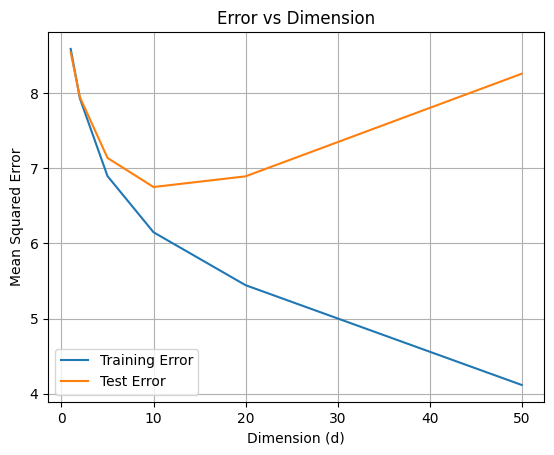

In [102]:
# Your code goes here
# Plot both train and test error as a function of d on the same plot.
plt.plot(dVal, train_error, label='Training Error')
plt.plot(dVal, test_error, label='Test Error')
plt.xlabel('Dimension (d)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.title('Error vs Dimension')
plt.show()

### Part (c)
Replacing all missing values by a constant may impose strong and potentially incorrect assumptions on the unobserved entries of $R$. A more reasonable choice is to minimize the mean squared error (MSE) only on rated movies. Define a loss function:
$$
\mathcal{L} \left( \{u_i\}_{i=1}^m, \{v_j\}_{j=1}^n \right) :=
\sum_{(i, j, R_{i, j}) \in {\rm train}} (\langle u_i,v_j\rangle - R_{i,j})^2 +
\lambda \sum_{i=1}^m \|u_i\|_2^2 +
\lambda \sum_{j=1}^n \|v_j\|_2^2
$$
where $\lambda > 0$ is the regularization coefficient. We will implement algorithms to learn vector representations by minimizing the above loss. You may need to tune $\lambda$ and $\sigma$ to optimize the loss.

Implement alternating minimization (as defined in the homework spec) and plot the MSE of ``train`` and ``test`` for $d \in \{1, 2, 5, 10, 20, 50\}$.

*Note: we define the loss function here as the sum of squared errors; be careful to calculate and plot the mean squared error for your results*

In [125]:
# Your code goes here. You are welcome to change the parameter lists and/or write new functions to complete this part of the assignment.
# In particular, you will likely also want to use R twiddle, and you may want to create global data structures to store observed entries.
# These global data structures might look like mappings of users to the movies they've reviewed, and of movies to the users who have reviewed that movie.

def closed_form_u(V, U, l):
  num_users = V.shape[1]
  for user_idx in range(num_users):
    rated_items = np.where(r_twiddle[:, user_idx] > 0)[0]
    R_user = r_twiddle[rated_items, user_idx]
    V_user = V[rated_items, :]

    if rated_items.shape[0] > 0:
      VtV = np.dot(V_user.T, V_user) + l * np.eye(V_user.shape[1])
      VtR = np.dot(V_user.T, R_user)
      U[user_idx, :] = np.linalg.solve(VtV, VtR)
  return U


def closed_form_v(V, U, l):
  num_items = U.shape[0]
  for item_idx in range(num_items):
    rated_users = np.where(r_twiddle[item_idx, :] > 0)[0]
    R_item = r_twiddle[item_idx, rated_users]
    U_item = U[rated_users, :]

    if rated_users.shape[0] > 0:
      UtU = np.dot(U_item.T, U_item) + l * np.eye(U_item.shape[1])
      UtR = np.dot(U_item.T, R_item)
      V[item_idx, :] = np.linalg.solve(UtU, UtR)
  return V


def construct_alternating_estimator(
    d, r_twiddle, l=10.0, delta=1e-1, sigma=0.1, U=None, V=None
):
  if U is None:
    U = sigma * np.random.randn(r_twiddle.shape[1], d)
  if V is None:
    V = sigma * np.random.randn(r_twiddle.shape[0], d)

  prev_U = np.copy(U)
  prev_V = np.copy(V)
  not_converged = True
  iteration = 0

  errors_train = []
  errors_test = []

  while not_converged:
    iteration += 1
    print(f"Iteration {iteration}...")
    U = closed_form_u(V, U, l)
    V = closed_form_v(V, U, l)

    max_diff = max(np.max(np.abs(U - prev_U)), np.max(np.abs(V - prev_V)))
    if max_diff < delta:
      not_converged = False
    else:
      prev_U = np.copy(U)
      prev_V = np.copy(V)

  R_hat = lambda user_index, movie_index: np.inner(U[user_index, :], V[movie_index, :])
  return find_error(train, R_hat), find_error(test, R_hat)

# Your code goes here
# Any additional functions that you may write to help implement alternating minimization.
def find_error(data, R_hat):
  error = []
  for (user_idx, movie_idx, rating) in data:
    predicted_rating = R_hat(user_idx, movie_idx)
    error.append((predicted_rating - rating) ** 2)
  return np.mean(error)

In [126]:
# Your code goes here
# Evaluate train and test error for: d = 1, 2, 5, 10, 20, 50.

index_map_i = {i: np.where(train[:, 1] == i)[0] for i in range(num_items)}
index_map_j = {j: np.where(train[:, 0] == j)[0] for j in range(num_users)}

dVals = [1, 2, 5, 10, 20, 50]
train_errors = []
test_errors = []

for d in dVals:
  print(f"Using d: {d}")
  errors_train, errors_test = construct_alternating_estimator(d, r_twiddle)
  train_errors.append(errors_train)
  test_errors.append(errors_test)

Using d: 1
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Using d: 2
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Using d: 5
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Iteration 13...
Iteration 14...
Iteration 15...
Using d: 10
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Using d: 20
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
Iteration 6...
Iteration 7...
Iteration 8...
Iteration 9...
Iteration 10...
Iteration 11...
Iteration 12...
Iteration 13...
Iteration 14...
Iteration 15...
Iteration 16...
Using d: 50
Iteration 1...
Iteration 2...
Iteration 3...


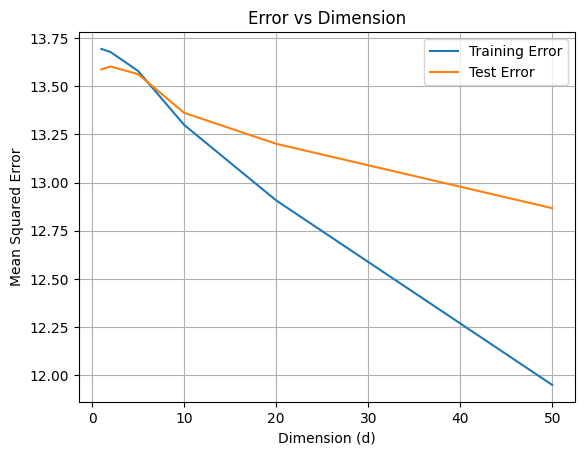

In [127]:
# Your code goes here
# Plot both train and test error as a function of d on the same plot.

plt.plot(dVal, train_errors, label='Training Error')
plt.plot(dVal, test_errors, label='Test Error')
plt.xlabel('Dimension (d)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.title('Error vs Dimension')
plt.show()